In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from PIL import Image
import os
import PIL
import glob
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
import xgboost as xgb
from xgboost import XGBRegressor
from math import sqrt
from sklearn.metrics import mean_squared_error

### Import Data

In [3]:
train_df = pd.read_csv("C:\\Users\\adeli\\Projects\\Kaggle\\StoreSales\\train.csv",parse_dates=['date']) #(3000888, 6)
test_df = pd.read_csv("C:\\Users\\adeli\\Projects\\Kaggle\\StoreSales\\test.csv",parse_dates=['date']) #(28512, 5), end date: 2017-08-31	
holidays_df = pd.read_csv("C:\\Users\\adeli\\Projects\\Kaggle\\StoreSales\\holidays_events.csv",parse_dates=['date']) #(350, 6)
oil_df = pd.read_csv("C:\\Users\\adeli\\Projects\\Kaggle\\StoreSales\\oil.csv",parse_dates=['date']) #(1218, 2), end date: 2017-08-31
stores_df = pd.read_csv("C:\\Users\\adeli\\Projects\\Kaggle\\StoreSales\\stores.csv") #(54, 5)
transactions_df = pd.read_csv("C:\\Users\\adeli\\Projects\\Kaggle\\StoreSales\\transactions.csv",parse_dates=['date']) #(83488, 3), end date: 2017-08-15

In [44]:
sample_submission_df = pd.read_csv("C:\\Users\\adeli\\Projects\\Kaggle\\StoreSales\\sample_submission.csv") #(83488, 3), end date: 2017-08-15

In [52]:
sample_submission_df.loc[1,:]

id       3000889.0
sales          0.0
Name: 1, dtype: float64

### Missing Values Data

In [4]:
df = pd.concat([train_df, test_df], sort=True) #3029400
df = df.merge(oil_df, on='date', how='left')
df = df.merge(stores_df, on='store_nbr', how='left')
df = df.merge(transactions_df, on=['date', 'store_nbr'], how='left')

In [36]:
print('Shape of data \t', df.shape)

Shape of data 	 (3029400, 11)


In [5]:
df.isnull().sum()

date                 0
family               0
id                   0
onpromotion          0
sales            28512
store_nbr            0
dcoilwtico      935550
city                 0
state                0
type                 0
cluster              0
transactions    274296
dtype: int64

In [6]:
complete_dates = df.date.unique()
df_oil_dates = pd.DataFrame(complete_dates)
df_oil_dates = df_oil_dates.rename(columns={0:'date'})

df_moving_avg_oil = df_oil_dates.merge(oil_df, on=['date'], how='left')
df_moving_avg_oil.dcoilwtico.bfill(axis ='rows', inplace=True)

df_moving_avg_oil.isnull().sum()

date          0
dcoilwtico    0
dtype: int64

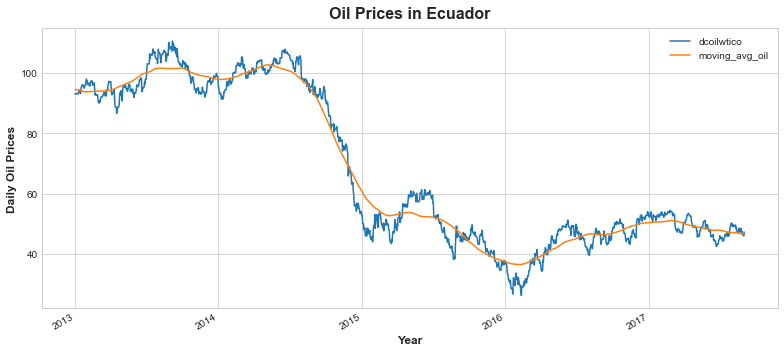

In [7]:
df_moving_avg_oil['moving_avg_oil'] = df_moving_avg_oil.rolling(
    window=180,       # Tested a couple window sizes to ensure bfill would result in zero null values
    center=True,      # puts the average at the center of the window
    min_periods=90,   # choose about half the window size
).mean()              # compute the mean

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)

df_moving_avg_oil['Year'] = df_moving_avg_oil['date'].dt.year

df_moving_avg_oil.plot.line(x='date', y=['dcoilwtico', 'moving_avg_oil'])

plt.xlabel('Year')
plt.ylabel('Daily Oil Prices')
plt.title("Oil Prices in Ecuador")

plt.show()

In [8]:
df = df.drop('dcoilwtico', axis=1)

df_moving_avg_oil=df_moving_avg_oil.drop(columns=['dcoilwtico','Year'])
df['date'] = pd.to_datetime(df['date'])
df = df.merge(df_moving_avg_oil, on='date', how='left')

In [9]:
df['transactions'] = df['transactions'].replace(np.nan, int(0))
df['sales'] = df['sales'].replace(np.nan, int(0))

df.isnull().sum()
#df = df.set_index('date').to_period('D')

date              0
family            0
id                0
onpromotion       0
sales             0
store_nbr         0
city              0
state             0
type              0
cluster           0
transactions      0
moving_avg_oil    0
dtype: int64

In [10]:
#df = df.set_index('date').to_period('D')

In [11]:
df2 = df.reset_index()
df2.set_index(['store_nbr', 'family', 'date'], inplace=True)
df2.sort_index(inplace=True)
df2 = df2.loc[:,['sales']]
#df2 = df2.loc[(slice(None),slice(None),pd.date_range('2017-01-01', '2017-08-15')),:]
df2 = df2.unstack(['store_nbr','family']).fillna(0.0).reset_index()
df2 = df2.set_index('date').to_period('D')

In [12]:
df2.dtypes

       store_nbr  family                    
sales  1          AUTOMOTIVE                    float64
                  BABY CARE                     float64
                  BEAUTY                        float64
                  BEVERAGES                     float64
                  BOOKS                         float64
                                                 ...   
       54         POULTRY                       float64
                  PREPARED FOODS                float64
                  PRODUCE                       float64
                  SCHOOL AND OFFICE SUPPLIES    float64
                  SEAFOOD                       float64
Length: 1782, dtype: object

In [13]:
# Trend & Seasonality
y = df2
fourier = CalendarFourier(freq='M', order=4) # 4 sin/cos pairs for "M"onthly seasonality
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=3,
    seasonal=True, #default weekly seasonalindicators
    additional_terms=[fourier],
    drop=True,
    )
X1 = dp.in_sample() 

# Holiday Indicators
holidays = holidays_df.set_index('date').to_period('D')
#Select national and regional holidays for 2017
holidays = holidays.loc[holidays.locale.isin(['Regional','National'])]
holidays = holidays.loc[:'2017-08-15',['description']]

#create dummy and add
X_holidays = pd.get_dummies(holidays['description'])
X1 = X_train.join(X_holidays, on='date').fillna(0.0)

In [39]:
#Cycles: leads and lags
X1.shape

(1700, 18)

In [41]:
y

sales                                                \
store_nbr          1                                                  
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2013-01-01        0.0       0.0    0.0       0.0   0.0        0.000   
2013-01-02        2.0       0.0    2.0    1091.0   0.0      470.652   
2013-01-03        3.0       0.0    0.0     919.0   0.0      310.655   
2013-01-04        3.0       0.0    3.0     953.0   0.0      198.366   
2013-01-05        5.0       0.0    3.0    1160.0   0.0      301.057   
...               ...       ...    ...       ...   ...          ...   
2017-08-27        0.0       0.0    0.0       0.0   0.0        0.000   
2017-08-28        0.0       0.0    0.0       0.0   0.0        0.000   
2017-08-29        0.0       0.0    0.0       0.0   0.0        0.000   
2017-08-30        0.0       0.0    0.0       0.0   0.0        0.000   
2017-08-31        0.0       0.0    0.0       0.0   0.0        0.000   

                                                 ...                    \
store_nbr                                        ...        54           
family     CELEBRATION CLEANING  DAIRY     DELI  ... MAGAZINES   MEATS   
date                                             ...                     
2013-01-01         0.0      0.0    0.0    0.000  ...       0.0   0.000   
2013-01-02         0.0   1060.0  579.0  164.069  ...       0.0  73.771   
2013-01-03         0.0    836.0  453.0  151.582  ...       0.0  50.257   
2013-01-04         0.0    827.0  460.0  131.411  ...       0.0  40.223   
2013-01-05         0.0    811.0  464.0  118.613  ...       0.0  43.431   
...                ...      ...    ...      ...  ...       ...     ...   
2017-08-27         0.0      0.0    0.0    0.000  ...       0.0   0.000   
2017-08-28         0.0      0.0    0.0    0.000  ...       0.0   0.000   
2017-08-29         0.0      0.0    0.0    0.000  ...       0.0   0.000   
2017-08-30         0.0      0.0    0.0    0.000  ...       0.0   0.000   
2017-08-31         0.0      0.0    0.0    0.000  ...       0.0   0.000   

                                                                       \
store_nbr                                                               
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS POULTRY   
date                                                                    
2013-01-01           0.0          0.0                     0.0   0.000   
2013-01-02         228.0          0.0                     0.0  15.514   
2013-01-03         156.0          0.0                     0.0   4.313   
2013-01-04         146.0          0.0                     0.0  26.743   
2013-01-05         205.0          0.0                     0.0  31.118   
...                  ...          ...                     ...     ...   
2017-08-27           0.0          0.0                     0.0   0.000   
2017-08-28           0.0          0.0                     0.0   0.000   
2017-08-29           0.0          0.0                     0.0   0.000   
2017-08-30           0.0          0.0                     0.0   0.000   
2017-08-31           0.0          0.0                     0.0   0.000   

                                                                      
store_nbr                                                             
family     PREPARED FOODS PRODUCE SCHOOL AND OFFICE SUPPLIES SEAFOOD  
date                                                                  
2013-01-01            0.0     0.0                        0.0     0.0  
2013-01-02           61.0     0.0                        0.0     3.0  
2013-01-03            1.0     0.0                        0.0     2.0  
2013-01-04           38.0     0.0                        0.0     2.0  
2013-01-05           32.0     0.0                        0.0     1.0  
...                   ...     ...                        ...     ...  
2017-08-27            0.0     0.0

In [15]:
y_train, y_valid = y[:"2017-07-01"], y["2017-07-02":]
X1_train, X1_valid = X1[: "2017-07-01"], X1["2017-07-02" :]
#X2_train, X2_valid = X_2.loc[:"2017-07-01"], X_2.loc["2017-07-02":]

In [16]:
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None #Don't store column names

In [33]:
def fit(self, X_1, X_2, y):
    self.model_1.fit(X_1, y)
    
    y_fit = pd.DataFrame(
    self.model_1.predict(X_1),
    index = X_1.index,
    columns = y.columns)
    
    #compuing residuals
    y_resid = y - y_fit
    y_resid = y_resid.stack().squeeze()
    
    #fit model 2 on residuals
    self.model_2.fit(X_2, y_resid)
    
    self.y_columns = y.columns #saving column names for predct method
    
BoostedHybrid.fit = fit #adding fit method to class

In [30]:
def predict(self, X_1, X_2):
    y_pred = pd.DataFrame(
    self.model_1.predict(X_1),
    index = X_1.index, columns=self.y_columns)
    
    y_pred = y_pred.stack().squeeze() #wide to long
    y_pred2 = self.model_2.predict(X_2)
    
    return y_pred.unstack() #long to wide

In [31]:
BoostedHybrid.predict = predict #adding predict method to class

In [19]:
df = df.set_index('date').to_period('D')

In [20]:
from sklearn import preprocessing
X2 = df[['family', 'onpromotion', 'store_nbr', 'moving_avg_oil']].copy()
le = preprocessing.LabelEncoder()
X2['family'] = le.fit_transform(X2.loc[:,'family'])
X2

,family,onpromotion,store_nbr,moving_avg_oil
date,,,,
2013-01-01,0,0,1,94.466556
2013-01-01,1,0,1,94.466556
2013-01-01,2,0,1,94.466556
2013-01-01,3,0,1,94.466556
2013-01-01,4,0,1,94.466556
...,...,...,...,...
2017-08-31,28,1,9,46.527473
2017-08-31,29,0,9,46.527473
2017-08-31,30,1,9,46.527473


In [34]:
model = BoostedHybrid(
    model_1 = LinearRegression(),
    model_2 = XGBRegressor())

model.fit(X1, X2, y)
#y_pred = model.predict(X1, X2)

#y_pred = y_red.clip(0.0)

In [35]:
y_pred = model.predict(X1, X2)


ValueError: Unable to coerce to Series, length must be 54: given 3029400

In [ ]:
rmse = sqrt(mean(square_error(test, y_pred))) #